In [2]:
#!/usr/bin/evn python

"""
CMSC733 Spring 2019: Classical and Deep Learning Approaches for
Geometric Computer Vision
Project1: MyAutoPano: Phase 1 Starter Code

Author(s): 
Chahat Deep Singh (chahat@terpmail.umd.edu) 
PhD Student in Computer Science,
University of Maryland, College Park

Nitin J. Sanket (nitinsan@terpmail.umd.edu)
PhD Candidate in Computer Science,
University of Maryland, College Park
"""

#Code starts here:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.feature import peak_local_max

In [3]:
def readImageSet(folder_name):
    print("Reading images from ", folder_name)
    images = []
    files = os.listdir(folder_name)	
    files = sorted(files)
    print("Found ", files)
    for file in files:
        image_path = folder_name + "/" + file
        image = cv2.imread(image_path)
        if image is not None:
            images.append(image)			
        else:
            print("Error in loading image ", image)

    return images


In [4]:
def displayImages(image_array, name):

    concat = image_array[0]
    print(concat.shape)
    for l in range(1,len(image_array)):
        concat = np.concatenate((concat, image_array[l]), axis = 1)
    cv2.imshow(name, concat)
    cv2.waitKey() 
    cv2.destroyAllWindows()


In [5]:
def detectCorners(images, choice):
    print("detecting corners ...")
    detected_corners = []
    cmaps = []
    corner_images = []
    for image in images:
        gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        gray_image = np.float32(gray_image)


        if(choice == 1):
            print("using Harris corner detection method.")
            corner_strength = cv2.cornerHarris(gray_image,2,3,0.04)
            corner_strength[corner_strength<0.01*corner_strength.max()] = 0
            detected_corner = np.where(corner_strength>0.001*corner_strength.max())
            detected_corners.append(detected_corner)
            cmaps.append(corner_strength)
            image[corner_strength > 0.001*corner_strength.max()]=[0,0,255]
            corner_images.append(image)
        else:
            print("using Shi-Tomashi corner detection method.")
            dst = cv2.goodFeaturesToTrack(gray_image, 250 ,0.01, 10)
            dst = np.int0(dst)
            detected_corners.append(dst)
            for c in dst:
                x,y = c.ravel()
                cv2.circle(image,(x,y),3,(0, 0, 255),-1) 
                          
            corner_images.append(image)
            cmap = np.zeros(gray_image.shape) #not sure what to do
            cmaps.append(cmap)

    return detected_corners, cmaps, corner_images

In [6]:
def getFeatureDescriptor(gray_image,x,y, patch_size=40):
    patch = gray_image[x-patch_size//2:x+patch_size//2, y-patch_size//2:y+patch_size//2] 
    # gaussian blur
    patch = cv2.GaussianBlur(patch,(3,3),0)
    # subsample to 20% size or 1/5th
    patch = cv2.resize(patch, None, fx=0.2, fy=0.2, interpolation = cv2.INTER_CUBIC)
    feature = patch.reshape(-1)
    feature = (feature-feature.mean())/ np.std(feature)

    return feature

In [7]:
def getPairs(image_1, image_2, all_corners_1, all_corners_2, patch_size = 40, alpha = 0.8):

    gray_image1 = cv2.cvtColor(image_1,cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(image_2,cv2.COLOR_BGR2GRAY)

    width, height = image_1.shape[:2]
    print("width = ", width, ", height = ", height)
    features_1,features_2 = [], []
    corners_1, corners_2 = [],[]

    print("all corner 1 len = ", len(all_corners_1))
    print("all corner 2 len = ", len(all_corners_2))
    
    for corner in all_corners_1:
        x,y = corner.ravel()
        
        if (x - (patch_size / 2) > 0) & (x + (patch_size / 2) < height) & (y - (patch_size / 2) > 0) & (y + (patch_size / 2) < width):
            features_1.append(getFeatureDescriptor(gray_image1, y,x)) 
            corners_1.append([x,y])
        else:
            #print("ignored x, y", x, y)
            pass

    for corner in all_corners_2:
        x,y = corner.ravel()
        if (x - (patch_size / 2) > 0) & (x + (patch_size / 2) < height) & (y - (patch_size / 2) > 0) & (y + (patch_size / 2) < width):
            features_2.append(getFeatureDescriptor(gray_image2, y,x)) 
            corners_2.append([x,y]) 

    matched_pairs, match_level = [], []
    for i, feat_1 in enumerate(features_1):
        ssd = []  
        for j, feat_2 in enumerate(features_2):
            ssd.append(np.sum((feat_1 - feat_2)**2))
        top_matche = np.argmin(ssd)
        #if ssd[top_matches[0]] / ssd[top_matches[1]] < alpha:   
            #matched_pairs.append([corners_1[i] , corners_2[top_matches[0]]])
        matched_pairs.append([corners_1[i] , corners_2[top_matche]]) 
    print("matched pairs num = ", len(matched_pairs))
    matched_pairs = np.array(matched_pairs)
    return matched_pairs

In [8]:
def showMatches(image_1, image_2, matched_pairs, partition_width = 20):
    

    concat = np.concatenate((image_1, image_2), axis = 1)
    corners_1 = matched_pairs[:,0].copy()
    corners_2  = matched_pairs[:,1].copy()
    corners_2[:,0] += image_1.shape[1]

    for (x1,y1) , (x2,y2) in zip(corners_1, corners_2):
        cv2.line(concat, (x1,y1), (x2,y2), (0, 0, 255), 1)
    
      
    cv2.imshow('Feature_matches', concat)
    cv2.waitKey() 
    cv2.destroyAllWindows()


In [9]:
def testShowMatches(image_1, image_2, partition_width = 20):
    matched_pairs= []
    I = np.linspace(10, 100, 10)
    for i in I:
        x1 = i
        y1 = i
        corner1 = np.int0(np.array([x1, y1]))

        x2 = i
        y2 = i
        corner2 = np.int0(np.array([x2, y2]))
        matched_pairs.append([corner1 , corner2])

    matched_pairs = np.array(matched_pairs)
    showMatches(image_1, image_2, matched_pairs, partition_width = 20)


In [10]:
def filterOutliers(matched_pairs, outliers, accuracy, thresh):

    set1 = matched_pairs[:, 0]
    set2 = matched_pairs[:, 1]

    N_best = 0
    H_best = np.zeros([3, 3])
    
    e = outliers / set1.shape[0]
    s = 4
    p = accuracy
    iterations = np.log(1 - p) / np.log(1 - np.power((1 - e), s))
    iterations = np.int(iterations)
    iterations = 4000

    filtered_pair_indices = []

    print("iterations = ", iterations)
    for i in range(iterations):
        #randomly select four points
        n_rows = set1.shape[0]
        random_indices = np.random.choice(n_rows, size=4)

        set1_random = set1[random_indices]
        set2_random = set2[random_indices]
              
        #compute homography
        H = cv2.getPerspectiveTransform(np.float32(set1_random), np.float32(set2_random))

        set1_dash = np.vstack((set1[:,0], set1[:,1], np.ones([1, n_rows])))
        set1_transformed_dash = np.dot(H, set1_dash)
        
        t1 = set1_transformed_dash[0,:]/set1_transformed_dash[2,:]
        t2 = set1_transformed_dash[1,:]/set1_transformed_dash[2,:]

        set1_transformed = np.array([t1, t2]).T
        #print(set1_transformed.shape)

        E = calculateError(set2, set1_transformed)
        
     
        E[E <= thresh] = 1
        E[E > thresh] = 0
    
    
        N = np.sum(E)


        if N > N_best:
            N_best = N
            H_best = H
            filtered_pair_indices = np.where(E == 1)
    
    filtered_set1 =  set1[filtered_pair_indices]
    filtered_set2 =  set2[filtered_pair_indices]

    print("Number of pairs after filtering = ", filtered_set1.shape[0])

    filter_matched_pairs = np.zeros([filtered_set1.shape[0], filtered_set1.shape[1], 2])

    filter_matched_pairs[:, 0, :] = filtered_set1
    filter_matched_pairs[:, 1, :] = filtered_set2

    filter_matched_pairs = filter_matched_pairs.astype(int)

    H_inbuit, _ = cv2.findHomography(set1, set2)
    print("inbuilt = ", H_inbuit)
    print("Computed = ", H_best)

    return H_best, filter_matched_pairs

    

In [11]:
def calculateError(set1, set2):
   
    E = np.zeros(set1.shape[0])
    tmp = set2 - set1
    num = set1.shape[0]

    for n in range(num):
        E[n] = np.linalg.norm(tmp[n])
    return E


In [12]:
def AdaptiveNonMaximalSuppression(images, C_maps, N_best):

    anms_img = []
    anms_corners = []
    for i,image in enumerate(images):

        cmap = C_maps[i]
        local_maximas = peak_local_max(cmap, min_distance=10)
        n_strong = local_maximas.shape[0]
        
        r = [np.Infinity for i in range(n_strong)]
        x=np.zeros((n_strong,1))
        y=np.zeros((n_strong,1))
        eu_dist = 0

        for i in range(n_strong):
            for j in range(n_strong):
                x_j = local_maximas[j][0]
                y_j = local_maximas[j][1]

                x_i = local_maximas[i][0]
                y_i = local_maximas[i][1]

                if(cmap[x_j, y_j] > cmap[x_i, y_i]):
                    eu_dist = np.square(x_j - x_i) + np.square(y_j - y_i)
                if r[i] > eu_dist:
                    r[i] = eu_dist
                    x[i] = x_j
                    y[i] = y_j

        index = np.argsort(r)
        index = np.flip(index)
        index = index[0:N_best]
        x_best=np.zeros((N_best,1))
        y_best=np.zeros((N_best,1))

        for i in range(N_best):
            x_best[i] = np.int0(x[index[i]])
            y_best[i] = np.int0(y[index[i]]) 
            cv2.circle(image, (y_best[i], x_best[i]), 3, (0, 255, 0), -1)

        anms_corner = np.int0(np.concatenate((x_best, y_best), axis = 1))
        anms_corners.append(anms_corner)
        anms_img.append(image)
    return anms_corners, anms_img

In [13]:
def main():
    # Add any Command Line arguments here
    # Parser = argparse.ArgumentParser()
    # Parser.add_argument('--NumFeatures', default=100, help='Number of best features to extract from each image, Default:100')
    
    # Args = Parser.parse_args()
    # NumFeatures = Args.NumFeatures

    """
    Read a set of images for Panorama stitching
    """
    print("main")
    folder_name = "/home/sakshi/courses/CMSC733/sakshi_p1/Phase1/Data/Train/Set1"
    use_harris = False
    images = readImageSet(folder_name)
    displayImages(images, "image_set")

    """
    Corner Detection
    Save Corner detection output as corners.png
    1 = harris, 2 = shi-tomashi
    """
    choice = 2
    if use_harris:
        choice = 1

    detected_corners, cmaps, corner_images = detectCorners(images, choice)
    displayImages(corner_images, "corners")
    """
    Perform ANMS: Adaptive Non-Maximal Suppression
    Save ANMS output as anms.png
    """
    if (choice == 1):
        print("Applying ALMS.")
        detected_corners, anms_image = AdaptiveNonMaximalSuppression(images, cmaps, 500)
        displayImages(anms_image, "anms_output")
    else:
        print("goodFeaturesToTrack is already using ALMS.") #review

    """
    Feature Descriptors
    Save Feature Descriptor output as FD.png
    """
    """
    Feature Matching
    Save Feature Matching output as matching.png
    """
    matched_pairs = getPairs(images[0], images[1], detected_corners[0], detected_corners[1], patch_size = 40, alpha = 0.9 )
    showMatches(images[0], images[1], matched_pairs, partition_width = 20)
    """
    Refine: RANSAC, Estimate Homography
    """
    H,filtered_matched_pairs = filterOutliers(matched_pairs, 10, 0.9, 30)
    showMatches(images[0], images[1], filtered_matched_pairs, partition_width = 20)
    """
    Image Warping + Blending
    Save Panorama output as mypano.png
    """





In [14]:
if __name__ == '__main__':
    main()

main
Reading images from  /home/sakshi/courses/CMSC733/sakshi_p1/Phase1/Data/Train/Set1
Found  ['1.jpg', '2.jpg', '3.jpg']
(450, 600, 3)
detecting corners ...
using Shi-Tomashi corner detection method.
using Shi-Tomashi corner detection method.
using Shi-Tomashi corner detection method.
(450, 600, 3)
goodFeaturesToTrack is already using ALMS.
width =  450 , height =  600
all corner 1 len =  250
all corner 2 len =  250
matched pairs num =  187
iterations =  4000
Number of pairs after filtering =  92
inbuilt =  [[-8.56904928e-01 -1.90951356e+00  6.69680510e+02]
 [-2.85483403e-01 -6.37184149e-01  2.23443272e+02]
 [-1.27773234e-03 -2.85677072e-03  1.00000000e+00]]
Computed =  [[ 1.24544942e+00  1.74099380e-01 -9.13315008e+01]
 [ 2.95458512e-02  1.21517070e+00 -2.88798035e+02]
 [ 1.90527086e-04  2.67013480e-04  1.00000000e+00]]


In [14]:

# Add any Command Line arguments here
# Parser = argparse.ArgumentParser()
# Parser.add_argument('--NumFeatures', default=100, help='Number of best features to extract from each image, Default:100')

# Args = Parser.parse_args()
# NumFeatures = Args.NumFeatures

"""
Read a set of images for Panorama stitching
"""
print("main")
folder_name = "/home/sakshi/courses/CMSC733/sakshi_p1/Phase1/Data/Train/Set1"
use_harris = False
images = readImageSet(folder_name)
displayImages(images, "image_set")

"""
Corner Detection
Save Corner detection output as corners.png
1 = harris, 2 = shi-tomashi
"""
choice = 2
if use_harris:
    choice = 1

detected_corners, cmaps, corner_images = detectCorners(images, choice)
displayImages(corner_images, "corners")
"""
Perform ANMS: Adaptive Non-Maximal Suppression
Save ANMS output as anms.png
"""
if (choice == 1):
    print("Applying ALMS.")
    detected_corners, anms_image = AdaptiveNonMaximalSuppression(images, cmaps, 500)
    displayImages(anms_image, "anms_output")
else:
    print("goodFeaturesToTrack is already using ALMS.") #review

"""
Feature Descriptors
Save Feature Descriptor output as FD.png
"""
"""
Feature Matching
Save Feature Matching output as matching.png
"""
matched_pairs = getPairs(images[0], images[1], detected_corners[0], detected_corners[1], patch_size = 40, alpha = 0.9 )
showMatches(images[0], images[1], matched_pairs, partition_width = 20)
"""
Refine: RANSAC, Estimate Homography
"""
H,filtered_matched_pairs = filterOutliers(matched_pairs, 20, 0.9, 20)
showMatches(images[0], images[1], filtered_matched_pairs, partition_width = 20)
"""
Image Warping + Blending
Save Panorama output as mypano.png
"""


main
Reading images from  /home/sakshi/courses/CMSC733/sakshi_p1/Phase1/Data/Train/Set1
Found  ['1.jpg', '2.jpg', '3.jpg']
(450, 600, 3)
detecting corners ...
using Shi-Tomashi corner detection method.
using Shi-Tomashi corner detection method.
using Shi-Tomashi corner detection method.
(450, 600, 3)
goodFeaturesToTrack is already using ALMS.
width =  450 , height =  600
all corner 1 len =  250
all corner 2 len =  250
matched pairs num =  187
iterations =  4000
Number of pairs after filtering =  91
inbuilt =  [[-8.56904928e-01 -1.90951356e+00  6.69680510e+02]
 [-2.85483403e-01 -6.37184149e-01  2.23443272e+02]
 [-1.27773234e-03 -2.85677072e-03  1.00000000e+00]]
Computed =  [[ 1.14973022e+00  1.11418288e-01 -4.72854733e+01]
 [ 1.85747384e-02  1.21087565e+00 -2.84328581e+02]
 [-4.88525512e-06  4.61708054e-04  1.00000000e+00]]


'\nImage Warping + Blending\nSave Panorama output as mypano.png\n'

In [19]:
h,w,_ = images[0].shape
pts = np.float32([ [0,0],[0,h],[w,h],[w,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts, H)
img2 = cv2.polylines(images[1],[np.int32(dst)],True,255,3, cv2.LINE_AA)
cv2.imshow("original_image_overlapping.jpg", img2)
cv2.waitKey() 
cv2.destroyAllWindows()

In [ ]:
def warpTwoImages(img1, img2, H):

    '''warp img2 to img1 with homograph H'''
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]

    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)

    pts2_ = cv2.perspectiveTransform(pts2, H)
    
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate
    result = cv2.warpPerspective(img1, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img2

    return result

result = warpTwoImages(images[0], images[1], H)
plt.imshow(result)

In [115]:
matched_pairs = getPairs(images[1], images[2], detected_corners[1], detected_corners[2], patch_size = 40, alpha = 0.9 )
showMatches(images[1], images[2], matched_pairs, partition_width = 20)
"""
Refine: RANSAC, Estimate Homography
"""
H,filtered_matched_pairs = filterOutliers(matched_pairs, 20, 0.9, 20)
showMatches(images[1], images[2], filtered_matched_pairs, partition_width = 20)

width =  450 , height =  600
all corner 1 len =  250
all corner 2 len =  250
matched pairs num =  225
iterations =  4000
Number of pairs after filtering =  108
inbuilt =  [[-2.37208174e-02 -1.44515549e+00  3.89326914e+02]
 [-1.09222628e-02 -6.41471644e-01  1.72868400e+02]
 [-6.24719032e-05 -3.71088184e-03  1.00000000e+00]]
Computed =  [[ 9.94054047e-01  3.75982691e-01  2.06733739e+02]
 [-3.80640247e-02  1.16472828e+00  2.10999176e+00]
 [-1.88407246e-04  7.45915436e-04  1.00000000e+00]]


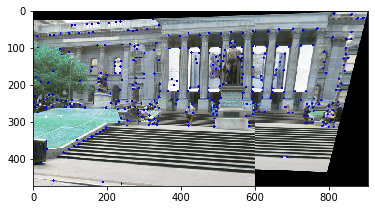

In [116]:
result = warpTwoImages(images[1], images[2], H)
plt.imshow(result)